In [22]:
import numpy as np
import matplotlib.pyplot as plt
import koopman as koop
from scipy import stats
from scipy.integrate import quad 
import scipy as sp
%load_ext autoreload
%autoreload 2

# Rotation on a circle

The stochastic equation is: $x_{t +1} = x_t + \nu + \omega t$
where $\nu$ is a fixed rotation angle and $\omega_t\sim Uniform[-0.5, 0.5]$. The function below generates a trajectory for number of time steps T, with rotation angle $\nu$ and initial condition $x_0$.

In [2]:
def circle_rotation(x0, T, nu):
    solution  = np.zeros(T)
    solution[0] = x0
    for i in range(1, T):
        # draw random number
        omega = np.random.rand() - 0.5
        # update
        solution[i] =np.mod(solution[i - 1] + nu + omega, 2*np.pi)
    return solution

Start by plotting a trajectory

Text(0.5, 1.0, 'Circle rotations for  100 time steps')

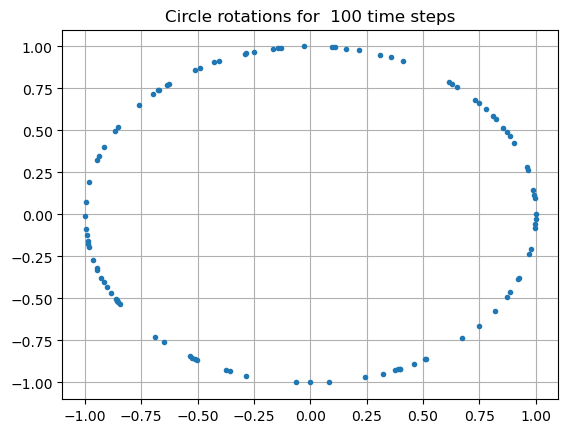

In [3]:
T = 100
rotation = circle_rotation(0, T, 0.5)
plt.plot(np.cos(rotation), np.sin(rotation), '.')
plt.grid()
plt.title('Circle rotations for  %i time steps' % T)

## L2 case
We start with densities which are normalized indicator functions on an equidistant partition of $[0, 2\pi]$ i.e.
$$g_i = 1_{\Big[i\frac{2\pi}{N},(i + 1)\frac{2\pi}{N}\Big]}, i \in \{0, \dots, N - 1\}$$

We sample K = 100 points from each measure and evolve them forward for T = 10 time steps. The data matrix is composed of the location of these $K*N$ points at time T.

First, we implemet a rejection sampling method for obtaining samples from $g_i$. We use the uniform distribution as the proposal.

In [4]:
def rejection_sample(pdf):
    while True:
        u = np.random.uniform()
        y = np.random.uniform()
        if u < pdf(y):
            return y
        

Set the hyperparameters

In [5]:
K = 1000
N = 10
T = 10
nu = 0.5

Generate the data matrix by:
- sampling K points out of each of the N distributions
- propagate the points through the dynamics for time T
- record their location in the data matrix

Here we use indicators as the distributions. We split the interval $[0, 2\pi]$ in N parts, and sample uniformly on each part. 

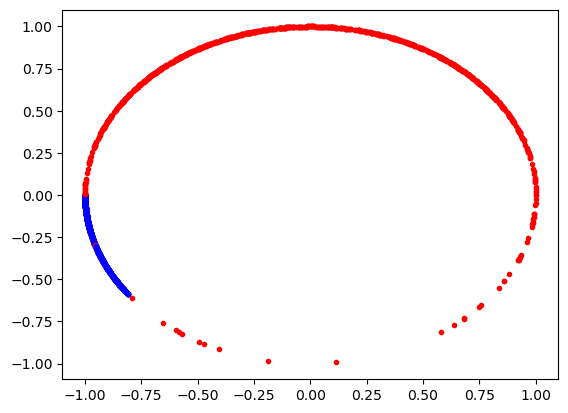

In [6]:
data = np.zeros((K, N))
data0 = np.zeros((K, N))
for i in range(N):
    # define the distributions to sample from if not uniform
    #f = lambda x:(i%2)*np.sin((i + 1)/2*x) - (i%2 - 1)*np.cos((i + 2)/2*x)
    for k in range(K):
        #x0 = rejection_sample(f)
        x0 = i* 2 * np.pi / N +  2 * np.pi / N * np.random.uniform()
        data0[k, i] = x0/(2*np.pi)

        xT = circle_rotation(x0, T, nu)
        
        # plot the samples and their images under the dynamics for specific measure 

        if i == 5:
            plt.plot(np.cos(x0), np.sin(x0), 'b.')
            plt.plot(np.cos(xT[-1]), np.sin(xT[-1]), 'r.')
        data[k, i] = xT[-1]/(2*np.pi)

Visualize the data as distributions on [0, 1]. We plot only a couple of distributions and their images under the transfer operator:

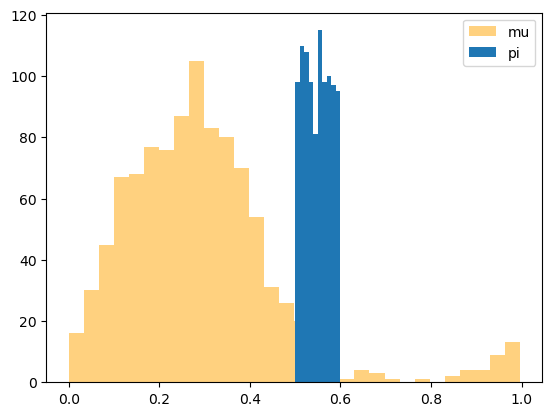

In [7]:
plt.hist(data[:, 5],  bins=30, alpha=0.5, label='mu', color='orange')
plt.hist(data0[:, 5], label = 'pi')
plt.legend()


Change the generating paradigm and generate a trajectory of $M  = 1000$ points with initial position $x_0 = 0$ and plot it.

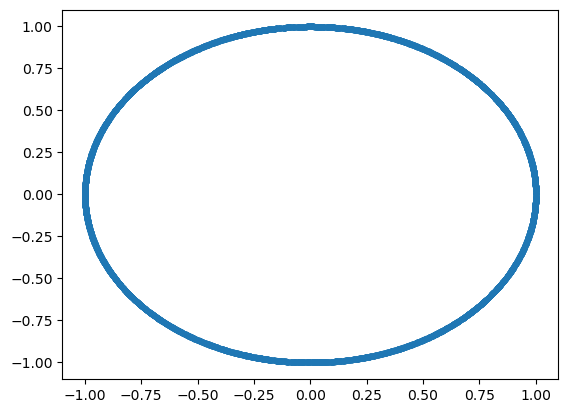

In [8]:
data_traj = circle_rotation(0, 10000, 0.5)
plt.plot(np.cos(data_traj), np.sin(data_traj), '.')
data_traj = data_traj/(2*np.pi)

Initiate the koopman object with N = 100 basis functions of type 'indicators'. 

In [9]:
K_circle = koop.koopman(10, 'indicators')

Perform the SKO DMD algorithm on the long trajectory as a sanity check:

In [10]:
K_circle.sko(data_traj)

In [11]:
evals, evects = np.linalg.eig(K_circle.mat)
evects = np.real(evects)

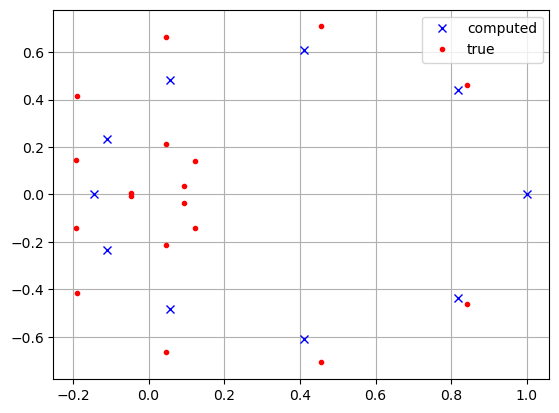

In [12]:
plt.plot(np.real(evals), np.imag(evals), 'bx', label = "computed")
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.')
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), - ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.', label = "true")
plt.legend()
plt.grid()

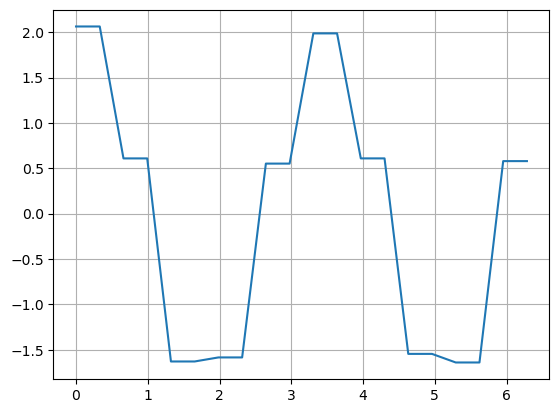

In [13]:
plt.plot(2*np.pi*np.linspace(0, 1, 10*2),2*np.pi* np.repeat(evects[:, 3], 2))
plt.grid()

In [14]:
K_circle.L2_dmd(data)

[[0.031 0.129 0.249 0.284 0.203 0.091 0.038 0.004 0.001 0.004]
 [0.006 0.04  0.13  0.243 0.286 0.215 0.081 0.024 0.006 0.002]
 [0.002 0.009 0.039 0.115 0.233 0.271 0.209 0.082 0.02  0.006]
 [0.004 0.002 0.011 0.04  0.114 0.232 0.271 0.191 0.088 0.023]
 [0.023 0.002 0.001 0.007 0.035 0.109 0.233 0.291 0.187 0.108]
 [0.078 0.032 0.002 0.001 0.009 0.04  0.126 0.224 0.284 0.189]
 [0.207 0.109 0.031 0.004 0.    0.008 0.029 0.132 0.235 0.277]
 [0.264 0.208 0.09  0.025 0.003 0.002 0.008 0.046 0.133 0.222]
 [0.248 0.265 0.2   0.094 0.022 0.006 0.002 0.006 0.033 0.132]
 [0.137 0.204 0.247 0.187 0.095 0.026 0.003 0.    0.013 0.037]]


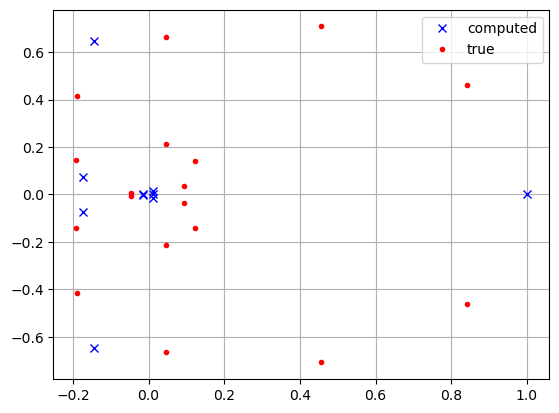

In [15]:
evals, evects = np.linalg.eig(K_circle.mat)
plt.plot(np.real(evals), np.imag(evals), 'bx', label = "computed")
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.')
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), - ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.', label = "true")
plt.legend()
plt.grid()

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


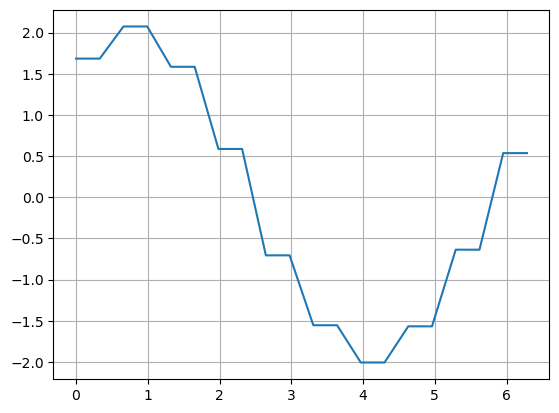

In [16]:
plt.plot(2*np.pi*np.linspace(0, 1, 20),2*np.pi* np.repeat(evects[:, 1], 2))
plt.grid()

In [17]:
M = np.shape(data_traj)[0]
E = np.zeros((N, M - 1))
D = np.zeros((N, M - 1))
for j in range(M - 1):
        E[int(np.floor(N*data_traj[j])), j] = 1
        D[int(np.floor(N*data_traj[ j + 1 ])), j] = 1

In [18]:
C = np.linalg.inv((E@E.T))@E@D.T

In [19]:
D_new = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        for k in range(K):
            if i/N <= data[k, j] < (i + 1)/N:
                D_new[i, j] += 1/K

In [30]:
C = K_circle.sup_dmd(data0, data)

array([[0.02397136, 0.98650017, 0.76528085, 0.07333047, 0.60968392,
        0.65556302, 0.80518753, 0.30302866, 0.34017607, 0.74273568],
       [0.53987517, 0.10096774, 0.21953108, 0.47247272, 0.03596452,
        0.81373306, 0.80571961, 0.0337039 , 0.77242798, 0.37715009],
       [0.15874973, 0.08129824, 0.87253169, 0.43464662, 0.57558347,
        0.98799276, 0.66279897, 0.6427853 , 0.66006946, 0.02623829],
       [0.40211265, 0.26279441, 0.11648136, 0.92111675, 0.48435386,
        0.60083206, 0.0944954 , 0.28091745, 0.51228064, 0.51612264],
       [0.42996765, 0.9605071 , 0.68155361, 0.82760713, 0.83975719,
        0.90487163, 0.59750155, 0.77631816, 0.58630252, 0.66550969],
       [0.11442501, 0.09709171, 0.60937748, 0.144151  , 0.1090638 ,
        0.61578671, 0.57501769, 0.20059115, 0.60566938, 0.55548073],
       [0.14596507, 0.42727472, 0.25018014, 0.79925782, 0.03276999,
        0.40773514, 0.44741731, 0.15775381, 0.73065182, 0.69408821],
       [0.02798804, 0.16712284, 0.6277025

In [31]:
C = np.array([[0.02397136, 0.98650017, 0.76528085, 0.07333047, 0.60968392,
        0.65556302, 0.80518753, 0.30302866, 0.34017607, 0.74273568],
       [0.53987517, 0.10096774, 0.21953108, 0.47247272, 0.03596452,
        0.81373306, 0.80571961, 0.0337039 , 0.77242798, 0.37715009],
       [0.15874973, 0.08129824, 0.87253169, 0.43464662, 0.57558347,
        0.98799276, 0.66279897, 0.6427853 , 0.66006946, 0.02623829],
       [0.40211265, 0.26279441, 0.11648136, 0.92111675, 0.48435386,
        0.60083206, 0.0944954 , 0.28091745, 0.51228064, 0.51612264],
       [0.42996765, 0.9605071 , 0.68155361, 0.82760713, 0.83975719,
        0.90487163, 0.59750155, 0.77631816, 0.58630252, 0.66550969],
       [0.11442501, 0.09709171, 0.60937748, 0.144151  , 0.1090638 ,
        0.61578671, 0.57501769, 0.20059115, 0.60566938, 0.55548073],
       [0.14596507, 0.42727472, 0.25018014, 0.79925782, 0.03276999,
        0.40773514, 0.44741731, 0.15775381, 0.73065182, 0.69408821],
       [0.02798804, 0.16712284, 0.62770258, 0.52350268, 0.30750352,
        0.34388084, 0.66752089, 0.32150856, 0.78748259, 0.93080159],
       [0.78887431, 0.95896651, 0.18948669, 0.42058254, 0.9007025 ,
        0.86926802, 0.2810935 , 0.58167147, 0.13282512, 0.3490914 ],
       [0.82987898, 0.52068139, 0.27358345, 0.76856826, 0.47121795,
        0.00595502, 0.4517781 , 0.98132759, 0.91591909, 0.7397179 ]])

In [33]:
C = np.reshape(C, (N, N))

In [36]:
eig, evect = np.linalg.eig(C)

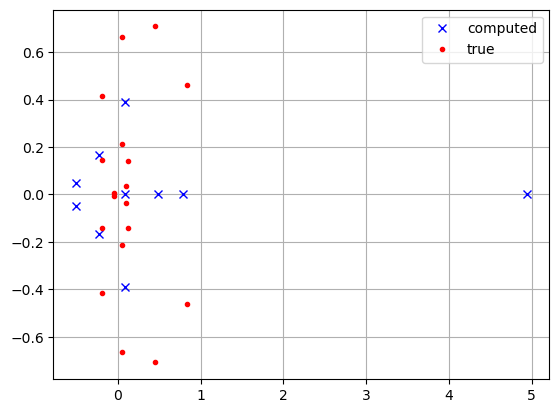

In [37]:
plt.plot(np.real(eig), np.imag(eig), 'bx', label = "computed")
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.')
plt.plot(np.sin(np.arange(1, 10))/np.arange(1, 10), - ( 1 - np.cos(np.arange(1, 10)))/np.arange(1, 10), 'r.', label = "true")
plt.legend()
plt.grid()